Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [596]:
#library versions
!pip install -U scikit-learn
!python -m pip show scikit-learn


Requirement already up-to-date: scikit-learn in /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages (0.23.1)
Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages
Requires: numpy, joblib, threadpoolctl, scipy
Required-by: sklearn, eli5, category-encoders


In [597]:
#importing data
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/JonRivera/JonRivera.github.io/master/Unit2/Buil_Week/Data_Sets/Hotel_Bookings/hotel_bookings.csv")

In [598]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [599]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [600]:
def wrangle(df):
    df = df.copy()
    #drop unecessary columns, or columns that seem to have little impact on target
    df = df.drop(['company', 'agent','arrival_date_week_number'],axis = 1)
    df = df.dropna(axis=0)  
    #set date column to index
    #doesn't add any substantial info, and has high cardinality. 
    #arrivate_date year,month, day already include this info ..
    df.set_index(pd.to_datetime(df['reservation_status_date']), inplace = True)
    df = df.drop(['reservation_status_date'], axis=1)
    #I am treating cancelations as people who canceled or did not show
    #on there arrival date --- it was assumend the hotel would cancel there stay 
    
    df['reservation_status'] =  df['reservation_status'].replace({'No-Show':'Canceled'})
    return df
df = wrangle(df)


In [601]:
#get train, validate,and test subsets
train = df[df['arrival_date_year']==2015].copy()
val = df[df['arrival_date_year']==2016].copy()
test = df[df['arrival_date_year'] == 2017].copy()
train.shape, val.shape, test.shape

((21859, 28), (56435, 28), (40604, 28))

In [792]:
pd.set_option('max_columns', 40)
train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,2015,July,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out
2015-07-01,Resort Hotel,0,737,2015,July,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out
2015-07-02,Resort Hotel,0,7,2015,July,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out
2015-07-02,Resort Hotel,0,13,2015,July,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out
2015-07-03,Resort Hotel,0,14,2015,July,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out


In [603]:
train.describe(exclude='number')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859
unique,2,6,5,98,6,5,9,11,3,4,2
top,City Hotel,September,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,13663,5084,17106,13303,6148,17691,17614,14376,18202,11319,13753


In [604]:
#feature selection
# is_canceled is also a target vector, reveals reservation_status implicitly ... is leaking information of target
def features_select(df):    
    target = 'reservation_status'
    #creating subsets of features, splitted between numerical and categorical
    train_features =  df.drop(columns = [target, 'is_canceled'],axis =1)
    numeric_features = train_features.select_dtypes(include='number').columns.tolist()
    cardinality = train_features.select_dtypes(exclude = 'number').nunique()
    categorical_features = cardinality.index.tolist()
    #combine lists to extrapolate features of interest
    features = numeric_features + categorical_features
    return features
features = features_select(df)


#These columns to be the most important ones, so I will do some feature engineering to see if i can improve my score

In [605]:
#seperating X matrices and correspind y vectors
target = 'reservation_status'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val= val[features]
y_val = val[target]
X_train.shape,y_train.shape,X_val.shape, y_val.shape

((21859, 26), (21859,), (56435, 26), (56435,))

In [606]:
#baselines
y_train.value_counts(normalize=True)


Check-Out    0.629169
Canceled     0.370831
Name: reservation_status, dtype: float64

##Permuation Importance

In [607]:
y_val.value_counts(normalize=True)


Check-Out    0.640064
Canceled     0.359936
Name: reservation_status, dtype: float64

Build Model

In [608]:
#instantitate classes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [609]:
#Build pipeline using RadnomSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model0 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs = -1, random_state=40)

)

param_distributions = { 
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': [5,10,20],
    'randomforestclassifier__min_samples_split': [5,10,15,20],
    'randomforestclassifier__min_samples_leaf': [2]
}
search = RandomizedSearchCV(
    model0, 
    param_distributions = param_distributions,
    n_iter = 10,
    cv=10,
    scoring ='accuracy',
    verbose = 1,
    return_train_score = True,
    n_jobs = -1
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator:' ,search.best_params_)
print('Best Model', search.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Cross-validation Best Score 0.8347639754543685
Best Estimator: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'entropy'}
Best Model Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
             

In [610]:
model0 = search.best_estimator_

In [611]:
model0.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
                                         {'col': 'arrival_date_month',
                                          'data_type...
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64},
                                         {'col': 'customer_ty

In [612]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

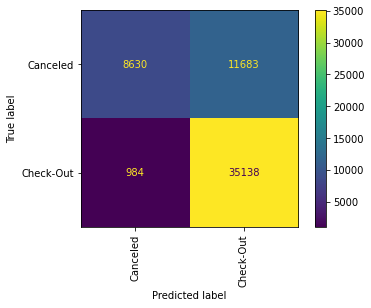

In [613]:
plot_confusion_matrix(model0, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [614]:
y_pred0 = model0.predict(X_val)

In [615]:
print(classification_report(y_val, y_pred0))

              precision    recall  f1-score   support

    Canceled       0.90      0.42      0.58     20313
   Check-Out       0.75      0.97      0.85     36122

    accuracy                           0.78     56435
   macro avg       0.82      0.70      0.71     56435
weighted avg       0.80      0.78      0.75     56435



In [616]:
!pip install xgboost
from xgboost import XGBClassifier

Model Importances

In [617]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance


Run XGBoost w/ Early Stopping to Prevent Overfitting and Optimize Estimators

In [618]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model1 = XGBClassifier(
        n_estimators = 100, #<=100 trees, but  #this dependens on early stopping too
        max_depth = 5,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model1.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 100)

[0]	validation_0-auc:0.95199	validation_1-auc:0.75255
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.96177	validation_1-auc:0.75369
[2]	validation_0-auc:0.96799	validation_1-auc:0.75729
[3]	validation_0-auc:0.97038	validation_1-auc:0.74851
[4]	validation_0-auc:0.97221	validation_1-auc:0.76796
[5]	validation_0-auc:0.97388	validation_1-auc:0.75801
[6]	validation_0-auc:0.97455	validation_1-auc:0.77523
[7]	validation_0-auc:0.97626	validation_1-auc:0.78594
[8]	validation_0-auc:0.97696	validation_1-auc:0.78500
[9]	validation_0-auc:0.97789	validation_1-auc:0.79331
[10]	validation_0-auc:0.97876	validation_1-auc:0.79618
[11]	validation_0-auc:0.97980	validation_1-auc:0.79321
[12]	validation_0-auc:0.98119	validation_1-auc:0.79333
[13]	validation_0-auc:0.98153	validation_1-auc:0.78949
[14]	validation_0-auc:0.98296	validation_1-auc:0.79185
[15]	validation_0-auc:0.983

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [619]:
model1.score(X_val_encoded,y_val)

0.773190396030832

In [620]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    model1,
    scoring = 'accuracy',
    n_iter= 5,
    random_state = 42
    )
permuter.fit(X_val_encoded,y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=5,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,
                                              

In [621]:
permuter.feature_importances_
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

deposit_type                      0.116669
country                           0.030385
previous_cancellations            0.013665
lead_time                         0.012269
required_car_parking_spaces       0.005550
assigned_room_type                0.004274
adr                               0.004132
reserved_room_type                0.003643
stays_in_week_nights              0.003282
previous_bookings_not_canceled    0.002413
booking_changes                   0.002403
total_of_special_requests         0.001538
arrival_date_day_of_month         0.001503
stays_in_weekend_nights           0.001350
hotel                             0.001290
distribution_channel              0.000918
meal                              0.000769
adults                            0.000684
market_segment                    0.000280
days_in_waiting_list              0.000198
children                          0.000046
arrival_date_year                 0.000000
babies                           -0.000060
is_repeated

In [622]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter,
    top=None, # shows permutation importances of all features
    feature_names = feature_names

)

Weight,Feature
0.1167 ± 0.0029,deposit_type
0.0304 ± 0.0011,country
0.0137 ± 0.0008,previous_cancellations
0.0123 ± 0.0006,lead_time
0.0055 ± 0.0005,required_car_parking_spaces
0.0043 ± 0.0005,assigned_room_type
0.0041 ± 0.0011,adr
0.0036 ± 0.0009,reserved_room_type
0.0033 ± 0.0008,stays_in_week_nights
0.0024 ± 0.0002,previous_bookings_not_canceled


In [623]:
permuter.feature_importances_

array([ 1.22689820e-02,  0.00000000e+00,  1.50261363e-03,  1.35022592e-03,
        3.28165146e-03,  6.83972712e-04,  4.60707008e-05, -6.02463011e-05,
       -2.02002304e-04,  1.36652786e-02,  2.41339594e-03,  2.40276424e-03,
        1.98458403e-04,  4.13218747e-03,  5.54974750e-03,  1.53805263e-03,
        1.28997962e-03, -1.73296713e-03,  7.69026313e-04,  3.03853991e-02,
        2.79968105e-04,  9.17870116e-04,  3.64312926e-03,  4.27394347e-03,
        1.16668734e-01, -1.13050412e-03])

In [624]:
y_pred1 = model1.predict(X_val_encoded)


In [625]:
#Feature Selection Based on Permuation Importances

In [626]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (21859, 26)


In [754]:
minimum_importance = 0.0001
permuter.feature_importances_ >minimum_importance

array([ True, False,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False])

In [755]:
mask = permuter.feature_importances_ > minimum_importance

In [756]:
features = list(X_train.columns[mask])
features

['lead_time',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type']

In [757]:
X_train1 = X_train[features]
print('Shape after removing features:', X_train1.shape)


Shape after removing features: (21859, 20)


In [758]:
X_val1 = X_val[features]
print('Shape after removing features:', X_val1.shape)

Shape after removing features: (56435, 20)


In [759]:
#Run XGBoost again w/ Early Stopping to prevent overfitting and too select optimal number of
#estimators
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train1)
X_val_encoded = encoder.transform(X_val1)

model1 = XGBClassifier(
        n_estimators = 300,
        max_depth = 2,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model1.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 300)

[0]	validation_0-auc:0.83878	validation_1-auc:0.67088
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[1]	validation_0-auc:0.92117	validation_1-auc:0.71675
[2]	validation_0-auc:0.93754	validation_1-auc:0.73121
[3]	validation_0-auc:0.93759	validation_1-auc:0.73129
[4]	validation_0-auc:0.94511	validation_1-auc:0.73548
[5]	validation_0-auc:0.94960	validation_1-auc:0.73963
[6]	validation_0-auc:0.95327	validation_1-auc:0.75450
[7]	validation_0-auc:0.95696	validation_1-auc:0.75316
[8]	validation_0-auc:0.95858	validation_1-auc:0.75458
[9]	validation_0-auc:0.96029	validation_1-auc:0.76820
[10]	validation_0-auc:0.96234	validation_1-auc:0.78814
[11]	validation_0-auc:0.96365	validation_1-auc:0.79050
[12]	validation_0-auc:0.96521	validation_1-auc:0.79982
[13]	validation_0-auc:0.96644	validation_1-auc:0.80500
[14]	validation_0-auc:0.96723	validation_1-auc:0.80978
[15]	validation_0-auc:0.967

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [846]:
y_val

reservation_status_date
2016-01-02    Check-Out
2016-01-02    Check-Out
2016-01-01     Canceled
2016-01-03    Check-Out
2015-12-22     Canceled
                ...    
2017-01-06    Check-Out
2017-01-06    Check-Out
2017-01-07    Check-Out
2017-01-08    Check-Out
2017-01-08    Check-Out
Name: reservation_status, Length: 56435, dtype: object

In [760]:
permuter1 = PermutationImportance(
    model1,
    scoring = 'accuracy',
    n_iter= 5,
    random_state = 42
    )
permuter1.fit(X_val_encoded,y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=2,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=500, n_jobs=-1,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,
                                              

In [761]:
feature_names1 = X_val1.columns.tolist()

In [762]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter1,
    top=None, # shows permutation importances of all features
    feature_names = feature_names1

)

Weight,Feature
0.1158 ± 0.0011,deposit_type
0.0269 ± 0.0013,country
0.0128 ± 0.0008,previous_cancellations
0.0078 ± 0.0007,required_car_parking_spaces
0.0073 ± 0.0007,lead_time
0.0040 ± 0.0007,reserved_room_type
0.0027 ± 0.0002,previous_bookings_not_canceled
0.0027 ± 0.0007,assigned_room_type
0.0017 ± 0.0006,hotel
0.0017 ± 0.0007,booking_changes


Eval_Metrics


In [763]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

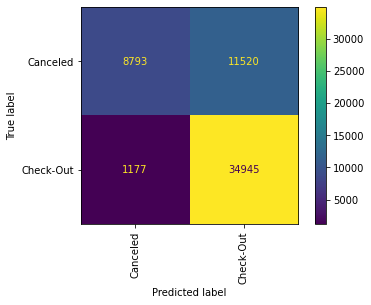

In [764]:
plot_confusion_matrix(model1, X_val_encoded, y_val, values_format='.0f', xticks_rotation='vertical');

In [765]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Canceled       0.85      0.45      0.59     20313
   Check-Out       0.76      0.95      0.84     36122

    accuracy                           0.77     56435
   macro avg       0.80      0.70      0.72     56435
weighted avg       0.79      0.77      0.75     56435



In [849]:
y_pred_probab1 = model1.predict_proba(X_val_encoded)
model1.classes_ 

array(['Canceled', 'Check-Out'], dtype=object)

In [767]:
roc_auc_score(y_val,y_pred_probab1[:,1])

0.8304105508495276

In [768]:
accuracy_score(y_val,y_pred1)

0.773190396030832

In [769]:
probs = model1.predict_proba(X_val_encoded)
probs

array([[6.3568354e-03, 9.9364316e-01],
       [4.2599440e-04, 9.9957401e-01],
       [1.5331650e-01, 8.4668350e-01],
       ...,
       [1.2420714e-02, 9.8757929e-01],
       [5.0711632e-04, 9.9949288e-01],
       [5.0711632e-04, 9.9949288e-01]], dtype=float32)

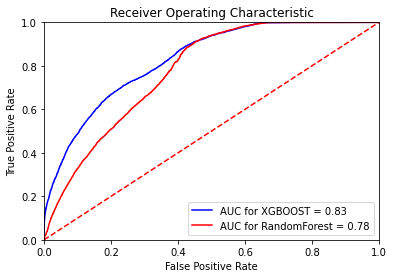

In [770]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs1 = model1.predict_proba(X_val_encoded)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_val, preds1, pos_label='Check-Out')
roc_auc1 = metrics.auc(fpr1, tpr1)

probs0 = model0.predict_proba(X_val)
preds0 = probs0[:,1]
fpr0, tpr0, threshold = metrics.roc_curve(y_val, preds0, pos_label ='Check-Out')
roc_auc0 = metrics.auc(fpr0, tpr0)


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc1)
plt.plot(fpr0, tpr0, 'r', label = 'AUC for RandomForest = %0.2f' % roc_auc0)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [844]:
model1.score(X_val_encoded,y_val)

0.7750155045627714

In [771]:
#.81 AUC before feature selection based on feature importances

In [ ]:
import matplotlib.pytplot as plt
plt.rcParams[]'figure.dpi'] = 72


Index(['lead_time', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel', 'meal', 'country',
       'market_segment', 'distribution_channel', 'reserved_room_type',
       'assigned_room_type', 'deposit_type'],
      dtype='object')

In [779]:
!pip install pdpbox

     |████████████████████████████████| 57.7 MB 869 kB/s eta 0:00:01    |█▊                              | 3.1 MB 1.1 MB/s eta 0:00:49
     |████████████████████████████████| 460 kB 826 kB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.0-py3-none-any.whl size=57690722 sha256=33e719b5207166ef05efc51fd1e2c72fa83de73861878521458dc9fb6aa11a4e
  Stored in directory: /Users/johnrivera/Library/Caches/pip/wheels/68/fe/64/20ca2c417f503c2d1e24f40b3eba7aba9cc3e6e681fadf7de1
  Created wheel for psutil: filename=psutil-5.7.2-cp37-cp37m-macosx_10_15_x86_64.whl size=234008 sha256=d963ebcc9567cfbb5910ae539f3617d460a7c1fa4a5015a6df4dec2091a49f61
  Stored in directory: /Users/johnrivera/Library/Caches/pip/wheels/2d/43/97/00701864a7bee6d9e1a52dd682537dcbf1d013d0e2e6f0c1f1
Successfully built pdpbox psutil


In [840]:
pd.options.display.max_rows = 50

In [841]:
# labels for encoded columns:
##looking at encoder mappings
encoder.mapping[2]

{'col': 'country',
 'mapping': PRT     1
 GBR     2
 USA     3
 ESP     4
 IRL     5
        ..
 GEO    95
 TMP    96
 MUS    97
 ECU    98
 NaN    -2
 Length: 99, dtype: int64,
 'data_type': dtype('O')}

In [839]:
encoder.mapping[-1]

{'col': 'deposit_type',
 'mapping': No Deposit    1
 Refundable    2
 Non Refund    3
 NaN          -2
 dtype: int64,
 'data_type': dtype('O')}

In [873]:

from pdpbox.pdp import pdp_isolate, pdp_plot
pdp_feature = 'country'
isolated = pdp_isolate(
    model=model1,
    dataset=X_val_encoded,
    model_features=feature_names1,
    feature=pdp_feature,
)

In [871]:
pdp_plot;

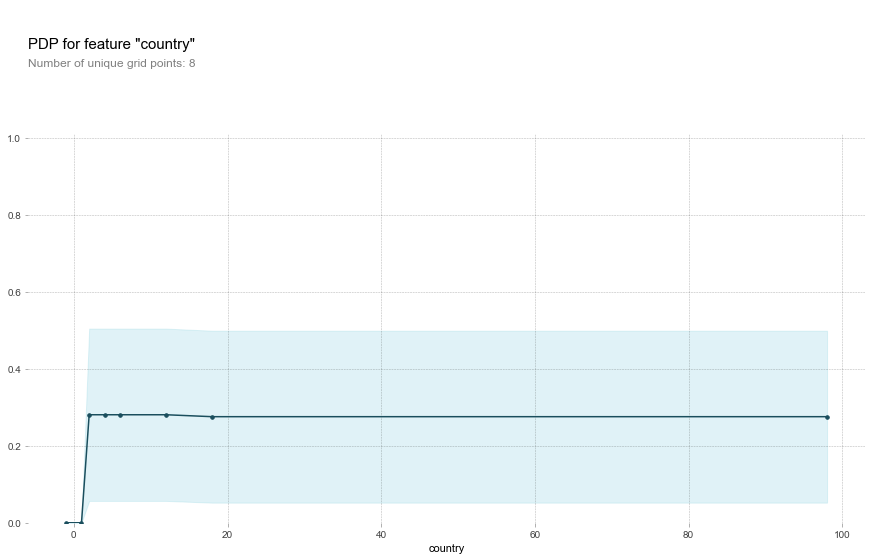

In [874]:
pdp_plot(isolated, feature_name= pdp_feature);

In [ ]:
# seems like most countries are expected to have an equal likeley hood of checking in

In [826]:
pdp_feature2 = 'deposit_type'
isolated = pdp_isolate(
    model=model1,
    dataset=X_val_encoded,
    model_features=feature_names1,
    feature=pdp_feature2

)

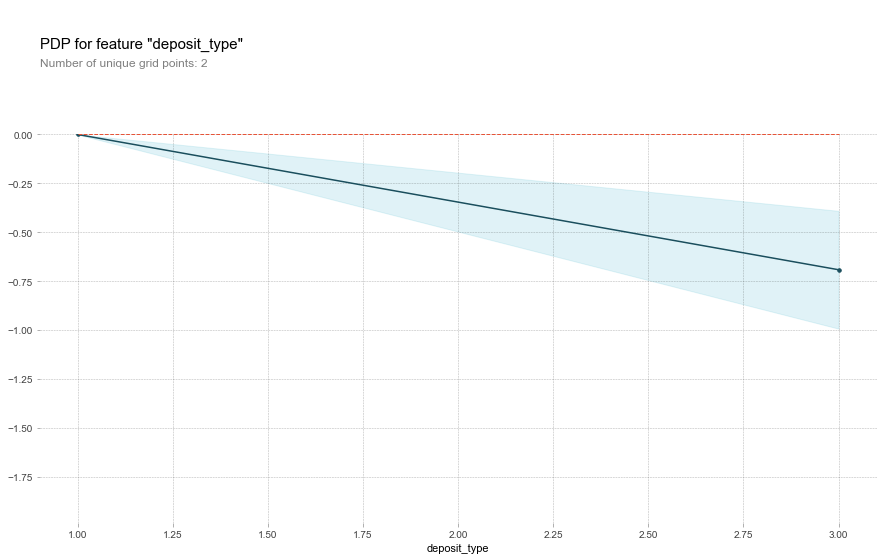

In [827]:
pdp_plot(isolated, feature_name= pdp_feature2);

In [ ]:
#I interpret this model as: if the person made a nonrefundable deposit, there is a higher likeley hood he will check in
# The converse seems to be true as swell , If the person did't make a deposit, there is a higher likeley he will canceled

In [850]:
#previous_cancellations

NameError: name 'previous_cancellations' is not defined